<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_PCA_SupersetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in California after PCA analysis 

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_Superset_dataset_Feb12.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Feb04.csv
 maryland_inertia_data_allstates_Feb05.csv
 maryland_inertia_data_allstates_Feb12.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Feb05.cs

In [3]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import median_absolute_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load superset data for CA

In [5]:
CA_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_Superset_dataset_Feb12.csv',low_memory=False)
CA_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,2020-03-01,California,6001,0,Alameda County,0.0000,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,37,26,2.9300,25.4000,0.4000,36.8000,0.2500,2.6800,0,1666753,-5.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0000,0.0000,37,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000
1,2020-03-02,California,6001,0,Alameda County,0.0000,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,17,20,3.3800,28.2000,0.4000,38.1000,0.6300,2.7400,0,1666753,-2.9000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0000,0.0000,38,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000
2,2020-03-03,California,6001,1,Alameda County,0.0000,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000,860.7571,California,CA,6001,Alameda County,6,16,18,3.6100,27.1000,0.3000,32.7000,0.6700,2.9400,1,1666753,4.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,1,0.0500,42,1.1000,5.3000,5.7000,0.6000,0.0000
3,2020-03-04,California,6001,0,Alameda County,0.0000,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,14,18,3.5500,27.9000,0.3000,36.9000,0.6800,2.8700,0,1666753,1.7000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400
4,2020-03-05,California,6001,0,Alameda County,0.0000,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000,860.7571,California,CA,6001,Alameda County,6,15,19,3.5400,28.1000,0.3000,36.8000,0.6600,2.8800,0,1666753,2.0000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400


## Group the data

In [6]:
CA_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [13]:
x_col_demographics = ['PopDensity','X..people.older.than.60',
                      'Median.income', 'X..African.Americans',
                      'X..Hispanic.Americans', 'X..Male','Date','New cases']

In [14]:
x_col_hospitalization_testing = ['Hospital.beds.1000.people',
       'ICUs.1000.people', 
       'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage','Date','New cases'] #'X..contact.tracing.workers.1000.people',

In [15]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home','Date','New cases']

In [16]:
x_col_socialdistancing = ['m50', 'm50_index','Social.distancing.index','Date','New cases']

In [17]:
x_col_maskrule = ['mask_rule_severity','Date','New cases']

# LSTM: Demographic Group

In [39]:
X_cols_all = x_col_demographics

X_cols_feature_selected = ['X..people.older.than.60', 'Median.income', 'X..Male',
                           'X..African.Americans', 'PopDensity'
                           ,'Date','New cases']


In [40]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 8)
(292, 7)


,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Date,New cases
4804,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-01,0
4805,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-02,0
4806,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-03,0
4807,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-04,6
4808,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-05,4


In [41]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [42]:
len(LA_combined_data_featured.columns)

7

In [43]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..people.older.than.60,Median.income,X..Male,X..African.Americans,PopDensity,Date,New cases
4804,18,64251,49.2800,7.9000,960.7428,1583020800.0000,0
4805,18,64251,49.2800,7.9000,960.7428,1583107200.0000,0
4806,18,64251,49.2800,7.9000,960.7428,1583193600.0000,0
4807,18,64251,49.2800,7.9000,960.7428,1583280000.0000,6
4808,18,64251,49.2800,7.9000,960.7428,1583366400.0000,4


In [44]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

7


X..people.older.than.60      int64
Median.income                int64
X..Male                    float64
X..African.Americans       float64
PopDensity                 float64
Date                       float64
New cases                    int64
dtype: object

## Preprocessing data for LSTM

In [45]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [46]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [47]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t)  var7(t)  var8(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 16 columns]


## Train Test Split

In [48]:
values.shape[0]

292

In [49]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 16)
(232, 1, 15) (232,) (59, 1, 15) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.4301 - val_loss: 0.8124
Epoch 2/100
4/4 - 0s - loss: 0.4058 - val_loss: 0.7735
Epoch 3/100
4/4 - 0s - loss: 0.3824 - val_loss: 0.7355
Epoch 4/100
4/4 - 0s - loss: 0.3599 - val_loss: 0.6978
Epoch 5/100
4/4 - 0s - loss: 0.3383 - val_loss: 0.6602
Epoch 6/100
4/4 - 0s - loss: 0.3180 - val_loss: 0.6228
Epoch 7/100
4/4 - 0s - loss: 0.2987 - val_loss: 0.5853
Epoch 8/100
4/4 - 0s - loss: 0.2805 - val_loss: 0.5488
Epoch 9/100
4/4 - 0s - loss: 0.2628 - val_loss: 0.5124
Epoch 10/100
4/4 - 0s - loss: 0.2461 - val_loss: 0.4767
Epoch 11/100
4/4 - 0s - loss: 0.2310 - val_loss: 0.4415
Epoch 12/100
4/4 - 0s - loss: 0.2177 - val_loss: 0.4080
Epoch 13/100
4/4 - 0s - loss: 0.2066 - val_loss: 0.3769
Epoch 14/100
4/4 - 0s - loss: 0.1988 - val_loss: 0.3495
Epoch 15/100
4/4 - 0s - loss: 0.1928 - val_loss: 0.3264
Epoch 16/100
4/4 - 0s - loss: 0.1885 - val_loss: 0.3077
Epoch 17/100
4/4 - 0s - loss: 0.1855 - val_loss: 0.2923
Epoch 18/100
4/4 - 0s - loss: 0.1833 - val_loss: 0.2805
E

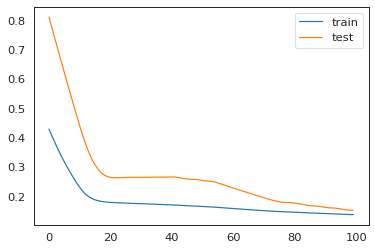

In [50]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [51]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 15)
Test MSE: 0.043
Test RMSE: 0.208
median_absolute_error 0.12862939
mean_absolute_error 0.15349914


## Preprocessing feature selected data for training

In [52]:
len(LA_combined_data_featured_selected.columns)

7

In [53]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)  var7(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 14 columns]


### Train Test split

In [54]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 14)
(232, 1, 13) (232,) (59, 1, 13) (59,)


### Training LSTM for feature selected data

In [55]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.3714 - val_loss: 0.6972
Epoch 2/200
4/4 - 0s - loss: 0.3477 - val_loss: 0.6588
Epoch 3/200
4/4 - 0s - loss: 0.3255 - val_loss: 0.6198
Epoch 4/200
4/4 - 0s - loss: 0.3042 - val_loss: 0.5803
Epoch 5/200
4/4 - 0s - loss: 0.2836 - val_loss: 0.5414
Epoch 6/200
4/4 - 0s - loss: 0.2637 - val_loss: 0.5021
Epoch 7/200
4/4 - 0s - loss: 0.2452 - val_loss: 0.4640
Epoch 8/200
4/4 - 0s - loss: 0.2290 - val_loss: 0.4267
Epoch 9/200
4/4 - 0s - loss: 0.2147 - val_loss: 0.3909
Epoch 10/200
4/4 - 0s - loss: 0.2029 - val_loss: 0.3581
Epoch 11/200
4/4 - 0s - loss: 0.1945 - val_loss: 0.3302
Epoch 12/200
4/4 - 0s - loss: 0.1883 - val_loss: 0.3072
Epoch 13/200
4/4 - 0s - loss: 0.1842 - val_loss: 0.2883
Epoch 14/200
4/4 - 0s - loss: 0.1814 - val_loss: 0.2737
Epoch 15/200
4/4 - 0s - loss: 0.1794 - val_loss: 0.2641
Epoch 16/200
4/4 - 0s - loss: 0.1782 - val_loss: 0.2583
Epoch 17/200
4/4 - 0s - loss: 0.1772 - val_loss: 0.2552
Epoch 18/200
4/4 - 0s - loss: 0.1765 - val_loss: 0.2538
E

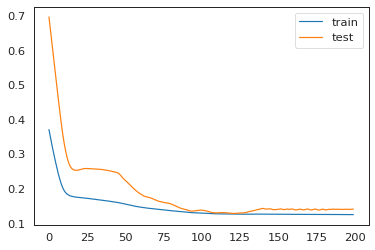

In [56]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [57]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 13)
Test MSE: 0.050
Test RMSE: 0.223
median_absolute_error 0.095648944
mean_absolute_error 0.14162844


# LSTM: Hospitalization and testing Group

In [58]:
X_cols_all = x_col_hospitalization_testing

X_cols_feature_selected = ['X..hospital.bed.utilization', 'Testing.capacity','Tests.done.1000.people'
                           ,'Date','New cases']


In [59]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 9)
(292, 5)


,Hospital.beds.1000.people,ICUs.1000.people,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Date,New cases
4804,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-01,0
4805,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-02,0
4806,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-03,0
4807,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,2020-03-04,6
4808,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,2020-03-05,4


In [60]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [61]:
len(LA_combined_data_featured.columns)

5

In [62]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,Date,New cases
4804,54.0000,0.0000,0.0000,1583020800.0000,0
4805,54.0000,0.0000,0.0000,1583107200.0000,0
4806,54.0000,0.0000,0.0000,1583193600.0000,0
4807,54.0000,10.3000,0.0100,1583280000.0000,6
4808,54.0000,10.3000,0.0100,1583366400.0000,4


In [63]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

5


X..hospital.bed.utilization    float64
Testing.capacity               float64
Tests.done.1000.people         float64
Date                           float64
New cases                        int64
dtype: object

## Preprocessing data for LSTM

In [64]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [65]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [66]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t)  var8(t)  var9(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0003   0.0166   0.0074

[5 rows x 18 columns]


## Train Test Split

In [67]:
values.shape[0]

292

In [68]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 18)
(232, 1, 17) (232,) (59, 1, 17) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3903 - val_loss: 0.7000
Epoch 2/100
4/4 - 0s - loss: 0.3448 - val_loss: 0.6231
Epoch 3/100
4/4 - 0s - loss: 0.3046 - val_loss: 0.5490
Epoch 4/100
4/4 - 0s - loss: 0.2672 - val_loss: 0.4749
Epoch 5/100
4/4 - 0s - loss: 0.2358 - val_loss: 0.4031
Epoch 6/100
4/4 - 0s - loss: 0.2128 - val_loss: 0.3378
Epoch 7/100
4/4 - 0s - loss: 0.1968 - val_loss: 0.2812
Epoch 8/100
4/4 - 0s - loss: 0.1869 - val_loss: 0.2370
Epoch 9/100
4/4 - 0s - loss: 0.1805 - val_loss: 0.2095
Epoch 10/100
4/4 - 0s - loss: 0.1769 - val_loss: 0.1982
Epoch 11/100
4/4 - 0s - loss: 0.1742 - val_loss: 0.1930
Epoch 12/100
4/4 - 0s - loss: 0.1719 - val_loss: 0.1922
Epoch 13/100
4/4 - 0s - loss: 0.1698 - val_loss: 0.1946
Epoch 14/100
4/4 - 0s - loss: 0.1678 - val_loss: 0.1992
Epoch 15/100
4/4 - 0s - loss: 0.1660 - val_loss: 0.2044
Epoch 16/100
4/4 - 0s - loss: 0.1643 - val_loss: 0.2087
Epoch 17/100
4/4 - 0s - loss: 0.1625 - val_loss: 0.2112
Epoch 18/100
4/4 - 0s - loss: 0.1606 - val_loss: 0.2124
E

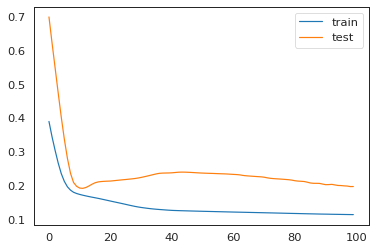

In [69]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [70]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 17)
Test MSE: 0.062
Test RMSE: 0.250
median_absolute_error 0.19815564
mean_absolute_error 0.1975508


## Preprocessing feature selected data for training

In [71]:
len(LA_combined_data_featured_selected.columns)

5

In [72]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

IndexError: ignored

### Train Test split

In [ ]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### Training LSTM for feature selected data

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [ ]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

# LSTM: Mobility Group + Social Distancing + Mask Rule

In [93]:
X_cols_all = x_col_mobility

X_cols_feature_selected = ['X..staying.home', 'X..working.from.home', 'workplaces_percent_change_from_baseline', 
                           'X..out.of.state.trips', 'parks_percent_change_from_baseline',
                           'm50', 'm50_index','Social.distancing.index',
                           'mask_rule_severity'
                           ,'Date','New cases']


In [74]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 16)
(292, 7)


,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..working.from.home,Date,New cases
4804,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,26,2.9100,11.2000,0.5000,35.1000,0.2600,2.6500,5.7000,2020-03-01,0
4805,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,19,3.4200,10.4000,0.4000,35.1000,0.7000,2.7100,5.7000,2020-03-02,0
4806,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,18,3.5700,10.2000,0.3000,33.7000,0.7300,2.8400,5.7000,2020-03-03,0
4807,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,18,3.4800,10.7000,0.3000,34.9000,0.7200,2.7600,5.7000,2020-03-04,6
4808,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,18,3.5200,10.7000,0.3000,36.4000,0.7200,2.8100,5.7000,2020-03-05,4


In [75]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [76]:
len(LA_combined_data_featured.columns)

7

In [77]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..staying.home,X..working.from.home,workplaces_percent_change_from_baseline,X..out.of.state.trips,parks_percent_change_from_baseline,Date,New cases
4804,26,5.7000,1.0000,0.5000,-5.0000,1583020800.0000,0
4805,19,5.7000,4.0000,0.4000,8.0000,1583107200.0000,0
4806,18,5.7000,3.0000,0.3000,32.0000,1583193600.0000,0
4807,18,5.7000,2.0000,0.3000,9.0000,1583280000.0000,6
4808,18,5.7000,2.0000,0.3000,9.0000,1583366400.0000,4


In [78]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

7


X..staying.home                              int64
X..working.from.home                       float64
workplaces_percent_change_from_baseline    float64
X..out.of.state.trips                      float64
parks_percent_change_from_baseline         float64
Date                                       float64
New cases                                    int64
dtype: object

## Preprocessing data for LSTM

In [79]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [80]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [81]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var14(t)  var15(t)  var16(t)
1     0.9512     0.6092     0.6337  ...    0.0000    0.0033    0.0000
2     0.9634     0.6322     0.7624  ...    0.0000    0.0066    0.0000
3     1.0000     0.6552     1.0000  ...    0.0000    0.0099    0.0186
4     0.9512     0.6437     0.7723  ...    0.0000    0.0132    0.0112
5     0.9512     0.6552     0.7723  ...    0.0000    0.0166    0.0074

[5 rows x 32 columns]


## Train Test Split

In [82]:
values.shape[0]

292

In [83]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 32)
(232, 1, 31) (232,) (59, 1, 31) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3266 - val_loss: 0.5784
Epoch 2/100
4/4 - 0s - loss: 0.2275 - val_loss: 0.4428
Epoch 3/100
4/4 - 0s - loss: 0.1866 - val_loss: 0.3494
Epoch 4/100
4/4 - 0s - loss: 0.1854 - val_loss: 0.3080
Epoch 5/100
4/4 - 0s - loss: 0.1897 - val_loss: 0.3098
Epoch 6/100
4/4 - 0s - loss: 0.1869 - val_loss: 0.3341
Epoch 7/100
4/4 - 0s - loss: 0.1833 - val_loss: 0.3651
Epoch 8/100
4/4 - 0s - loss: 0.1822 - val_loss: 0.3867
Epoch 9/100
4/4 - 0s - loss: 0.1823 - val_loss: 0.3962
Epoch 10/100
4/4 - 0s - loss: 0.1814 - val_loss: 0.3951
Epoch 11/100
4/4 - 0s - loss: 0.1790 - val_loss: 0.3866
Epoch 12/100
4/4 - 0s - loss: 0.1758 - val_loss: 0.3746
Epoch 13/100
4/4 - 0s - loss: 0.1728 - val_loss: 0.3624
Epoch 14/100
4/4 - 0s - loss: 0.1700 - val_loss: 0.3524
Epoch 15/100
4/4 - 0s - loss: 0.1677 - val_loss: 0.3452
Epoch 16/100
4/4 - 0s - loss: 0.1655 - val_loss: 0.3407
Epoch 17/100
4/4 - 0s - loss: 0.1634 - val_loss: 0.3382
Epoch 18/100
4/4 - 0s - loss: 0.1612 - val_loss: 0.3366
E

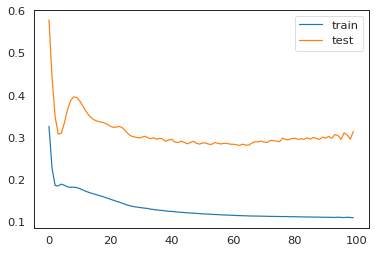

In [84]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [85]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 31)
Test MSE: 0.121
Test RMSE: 0.347
median_absolute_error 0.34011436
mean_absolute_error 0.31424418


## Preprocessing feature selected data for training

In [86]:
len(LA_combined_data_featured_selected.columns)

7

In [87]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)  var7(t)
1     0.2353     0.0000     0.9655  ...   0.7624   0.0033   0.0000
2     0.0294     0.0000     1.0000  ...   1.0000   0.0066   0.0000
3     0.0000     0.0000     0.9885  ...   0.7723   0.0099   0.0186
4     0.0000     0.0000     0.9770  ...   0.7723   0.0132   0.0112
5     0.0000     0.0000     0.9770  ...   0.7525   0.0166   0.0074

[5 rows x 14 columns]


### Train Test split

In [88]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 14)
(232, 1, 13) (232,) (59, 1, 13) (59,)


### Training LSTM for feature selected data

In [89]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.2567 - val_loss: 0.5253
Epoch 2/200
4/4 - 0s - loss: 0.2053 - val_loss: 0.4476
Epoch 3/200
4/4 - 0s - loss: 0.1812 - val_loss: 0.3864
Epoch 4/200
4/4 - 0s - loss: 0.1714 - val_loss: 0.3450
Epoch 5/200
4/4 - 0s - loss: 0.1686 - val_loss: 0.3223
Epoch 6/200
4/4 - 0s - loss: 0.1678 - val_loss: 0.3162
Epoch 7/200
4/4 - 0s - loss: 0.1667 - val_loss: 0.3221
Epoch 8/200
4/4 - 0s - loss: 0.1652 - val_loss: 0.3320
Epoch 9/200
4/4 - 0s - loss: 0.1640 - val_loss: 0.3413
Epoch 10/200
4/4 - 0s - loss: 0.1630 - val_loss: 0.3490
Epoch 11/200
4/4 - 0s - loss: 0.1621 - val_loss: 0.3536
Epoch 12/200
4/4 - 0s - loss: 0.1608 - val_loss: 0.3535
Epoch 13/200
4/4 - 0s - loss: 0.1590 - val_loss: 0.3493
Epoch 14/200
4/4 - 0s - loss: 0.1568 - val_loss: 0.3428
Epoch 15/200
4/4 - 0s - loss: 0.1546 - val_loss: 0.3360
Epoch 16/200
4/4 - 0s - loss: 0.1524 - val_loss: 0.3314
Epoch 17/200
4/4 - 0s - loss: 0.1504 - val_loss: 0.3282
Epoch 18/200
4/4 - 0s - loss: 0.1485 - val_loss: 0.3256
E

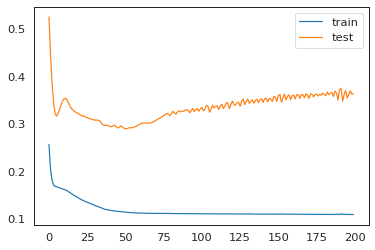

In [90]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [91]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 13)
Test MSE: 0.162
Test RMSE: 0.402
median_absolute_error 0.3788873
mean_absolute_error 0.3636518


# Conclusion for all dataset after PCA

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without PCA  | 0.117| 0.342|0.335|0.315|
|   with PCA  | 0.085| 0.291|0.272|0.264|